In [1]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet18

## Import Dataset

In [2]:
# Base path dataset asli (relatif ke notebook)
DATA_ROOT = 'Data'

# Original directories per kelas
original_dirs = {
    'Calculus': os.path.join(DATA_ROOT, 'Calculus'),
    'Caries': os.path.join(DATA_ROOT, 'Data caries', 'Data caries',
                            'caries augmented data set', 'preview'),
    'Gingivitis': os.path.join(DATA_ROOT, 'Gingivitis'),
    'Ulcers': os.path.join(DATA_ROOT, 'Mouth Ulcer', 'Mouth Ulcer',
                            'Mouth_Ulcer_augmented_DataSet', 'preview'),
    'Tooth Discoloration': os.path.join(
        DATA_ROOT, 'Tooth Discoloration', 'Tooth Discoloration',
        'Tooth_discoloration_augmented_dataser', 'preview'
    ),
    'Hypodontia': os.path.join(DATA_ROOT, 'hypodontia', 'hypodontia')
}

# Target base directory (hasil split)
base_dir = 'dataset'   # nanti jadi ./dataset/train, val, test

splits = ['train', 'val', 'test']
classes = list(original_dirs.keys())

# Create target directories
for split in splits:
    for class_name in classes:
        os.makedirs(os.path.join(base_dir, split, class_name), exist_ok=True)

# Initialize split counters
class_split_counts = {
    class_name: {'train': 0, 'val': 0, 'test': 0}
    for class_name in classes
}

In [3]:
# Function to copy images to the target directory and count them
def copy_and_count_images(class_name, image_paths):
    # Split the data
    train_paths, test_paths = train_test_split(image_paths, test_size=0.1, random_state=42)
    train_paths, val_paths = train_test_split(train_paths, test_size=0.2, random_state=42)  # 0.2 * 0.9 = 0.18

    # Define split mappings
    split_paths = {
        'train': train_paths,
        'val': val_paths,
        'test': test_paths
    }

    # Copy images to their respective directories and count them
    for split, paths in split_paths.items():
        class_split_counts[class_name][split] = len(paths)
        for img_path in paths:
            target_path = os.path.join(base_dir, split, class_name, os.path.basename(img_path))
            shutil.copy(img_path, target_path)

In [4]:
# Traverse the original directories and gather image paths
for class_name, original_dir in original_dirs.items():
    image_paths = []
    for root, dirs, files in os.walk(original_dir):
        image_paths.extend([os.path.join(root, file) for file in files if file.endswith(('.jpg', '.jpeg', '.png'))])
    if image_paths:
        copy_and_count_images(class_name, image_paths)

print("Images have been copied and organized successfully.")

Images have been copied and organized successfully.


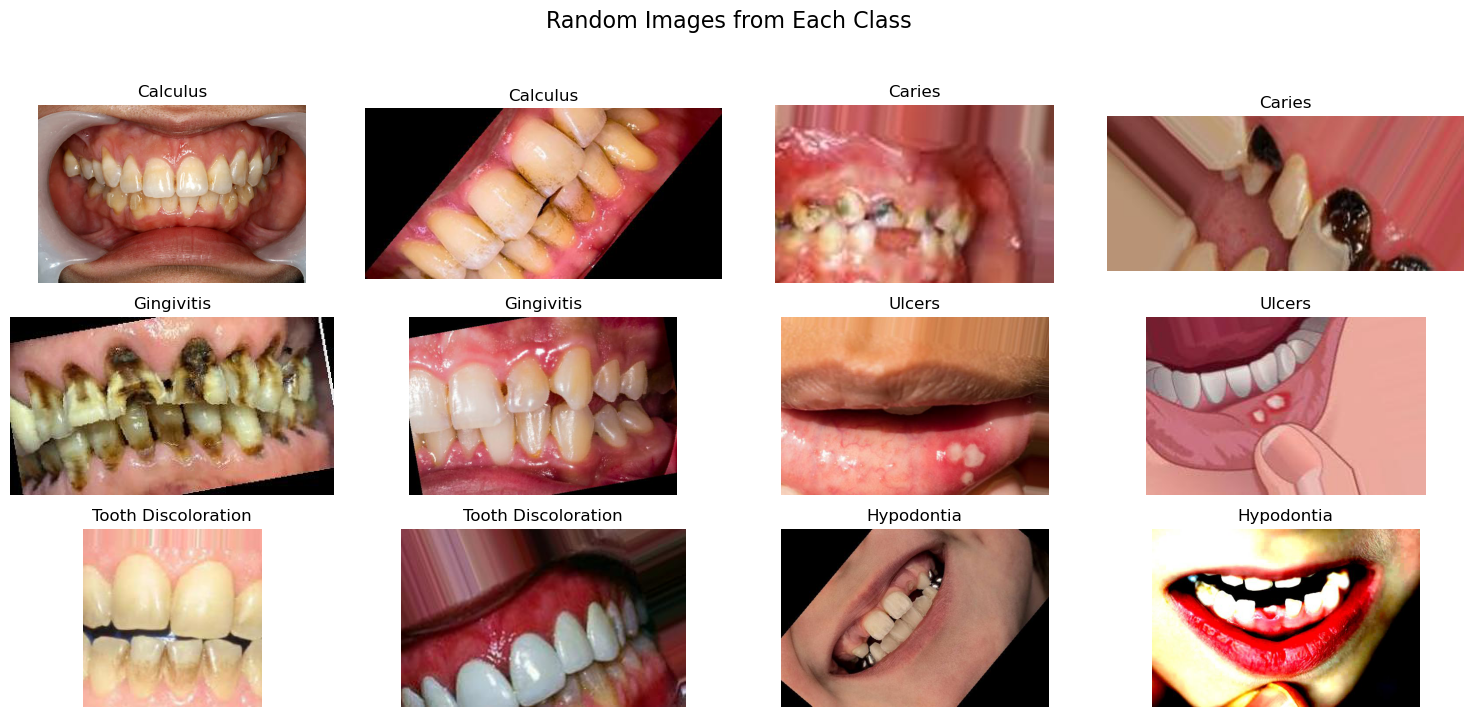

In [5]:
# Number of images to display per class and per row
num_images_per_class = 2
num_images_per_row = 4

# Set seed for reproducibility
random.seed(42)

# Function to get random images from a directory
def get_random_images_from_dir(directory, num_images):
    all_images = [os.path.join(directory, img) for img in os.listdir(directory) if img.endswith(('.jpg', '.jpeg', '.png'))]
    if len(all_images) < num_images:
        return all_images
    return random.sample(all_images, num_images)

# Create a figure
num_rows = (len(classes) * num_images_per_class + num_images_per_row - 1) // num_images_per_row  # Calculate number of rows needed
fig, axs = plt.subplots(num_rows, num_images_per_row, figsize=(15, num_rows * 2.5))
fig.suptitle('Random Images from Each Class', fontsize=16)

# Flatten axs array for easier indexing
axs = axs.flatten()

# Iterate through classes and display images
image_idx = 0
for class_name in classes:
    class_dir = os.path.join(base_dir, 'train', class_name)
    random_images = get_random_images_from_dir(class_dir, num_images_per_class)
    
    for img_path in random_images:
        if image_idx < len(axs):
            img = Image.open(img_path)
            ax = axs[image_idx]
            ax.imshow(img)
            ax.set_title(class_name)
            ax.axis('off')
            image_idx += 1

# Hide any unused subplots
for i in range(image_idx, len(axs)):
    axs[i].axis('off')

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Data Visualization

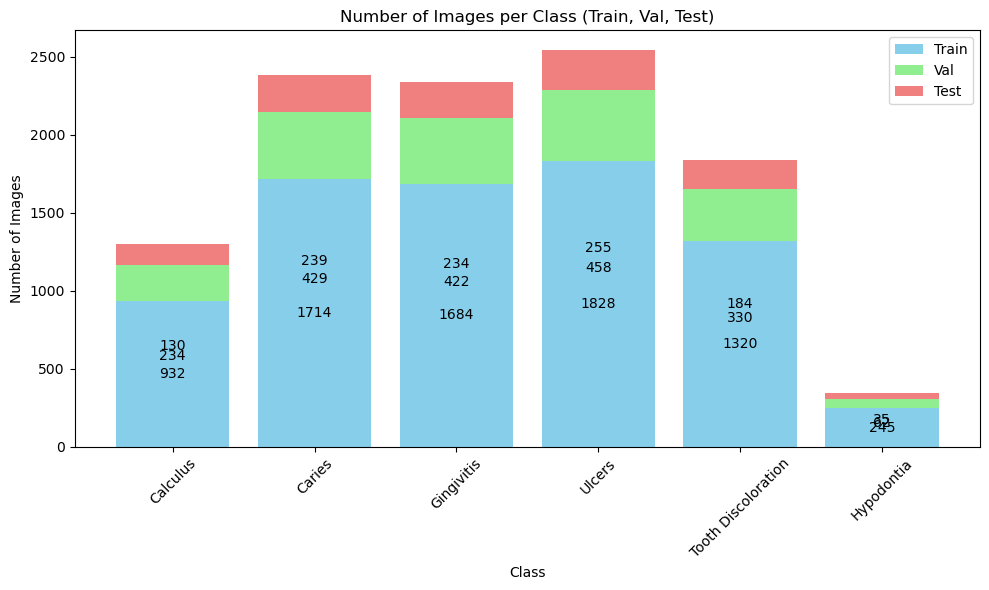

In [6]:
# Initialize dictionaries to hold the counts for train, val, and test sets
class_split_counts = {class_name: {'train': 0, 'val': 0, 'test': 0} for class_name in classes}

# Function to count images in each split
def count_images(base_dir, class_name):
    counts = {}
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(base_dir, split, class_name)
        counts[split] = len(os.listdir(split_dir))
    return counts

# Calculate counts for each class and split
for class_name in classes:
    class_split_counts[class_name] = count_images(base_dir, class_name)

# Create lists for the bar plot
labels = classes
train_counts = [class_split_counts[class_name]['train'] for class_name in classes]
val_counts = [class_split_counts[class_name]['val'] for class_name in classes]
test_counts = [class_split_counts[class_name]['test'] for class_name in classes]

x = range(len(classes))

# Create the stacked bar plot
fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(x, train_counts, label='Train', color='skyblue')
bar2 = ax.bar(x, val_counts, bottom=train_counts, label='Val', color='lightgreen')
bar3 = ax.bar(x, test_counts, bottom=[i+j for i,j in zip(train_counts, val_counts)], label='Test', color='lightcoral')

ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images per Class (Train, Val, Test)')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

# Add data labels
for bar in bar1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval / 2, int(yval), ha='center', va='center', color='black')

for bar in bar2:
    yval = bar.get_height() + bar.get_y()
    ax.text(bar.get_x() + bar.get_width()/2, yval / 2, int(bar.get_height()), ha='center', va='center', color='black')

for bar in bar3:
    yval = bar.get_height() + bar.get_y()
    ax.text(bar.get_x() + bar.get_width()/2, yval / 2, int(bar.get_height()), ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

## Model Prepare

In [7]:
# Define directories
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Parameters
image_size = (128, 128)
batch_size = 16
num_epochs = 50

# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Normalization for validation and testing
val_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = ImageFolder(train_dir, transform=train_transforms)
val_dataset = ImageFolder(val_dir, transform=val_transforms)
test_dataset = ImageFolder(test_dir, transform=val_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [8]:
# Get number of classes
num_classes = len(train_dataset.classes)

# Use a smaller model - ResNet18
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.model = resnet18(weights=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize the model, loss function, and optimizer
model = CustomModel()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

c:\Users\Muhammad Ade Aulia\miniconda3\envs\gpu_load\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Set environment variable to avoid threading issues
os.environ["OMP_NUM_THREADS"] = "1"

# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Early stopping parameters
early_stopping = True
patience = 3  # Number of epochs to wait if no improvement is observed

# Initialize early stopping variables
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

# Initialize lists to store losses, accuracies, and learning rates
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Variables to store y_true and y_scores for precision-recall calculation
y_true = []
y_scores = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_true = []
    val_outputs = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_true.extend(labels.cpu().numpy())
            val_outputs.extend(outputs.cpu().numpy())

    val_loss = val_loss / len(val_dataset)
    val_acc = accuracy_score(val_true, val_preds)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Append true labels and predicted scores for precision-recall calculation
    y_true.extend(val_true)
    y_scores.extend(val_outputs)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Check for improvement in validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the model checkpoint here if you want

    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Early stopping after {epoch+1} epochs.')
            early_stop = True
            break

    # LR scheduler step based on validation loss
    scheduler.step(val_loss) 

    if early_stop:
        break

c:\Users\Muhammad Ade Aulia\miniconda3\envs\gpu_load\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50], Train Loss: 0.9289, Val Loss: 0.9144, Val Acc: 0.6434
Epoch [2/50], Train Loss: 0.6655, Val Loss: 0.7954, Val Acc: 0.7183
Epoch [3/50], Train Loss: 0.5645, Val Loss: 0.6721, Val Acc: 0.7251
Epoch [4/50], Train Loss: 0.4766, Val Loss: 0.6008, Val Acc: 0.7618
Epoch [5/50], Train Loss: 0.4438, Val Loss: 0.3946, Val Acc: 0.8486
Epoch [6/50], Train Loss: 0.3974, Val Loss: 0.4117, Val Acc: 0.8372
Epoch [7/50], Train Loss: 0.3633, Val Loss: 0.3720, Val Acc: 0.8517
Epoch [8/50], Train Loss: 0.3425, Val Loss: 0.3474, Val Acc: 0.8537
Epoch [9/50], Train Loss: 0.3218, Val Loss: 0.3719, Val Acc: 0.8455
Epoch [10/50], Train Loss: 0.2997, Val Loss: 0.3169, Val Acc: 0.8641
Epoch [11/50], Train Loss: 0.2619, Val Loss: 0.3475, Val Acc: 0.8465
Epoch [12/50], Train Loss: 0.2816, Val Loss: 0.3436, Val Acc: 0.8506
Epoch [13/50], Train Loss: 0.2484, Val Loss: 0.3233, Val Acc: 0.8661
Early stopping after 13 epochs.


## Model Evaluation

In [10]:
# Test the model
model.eval()
test_preds = []
test_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_true.extend(labels.cpu().numpy())

test_acc = accuracy_score(test_true, test_preds)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8505


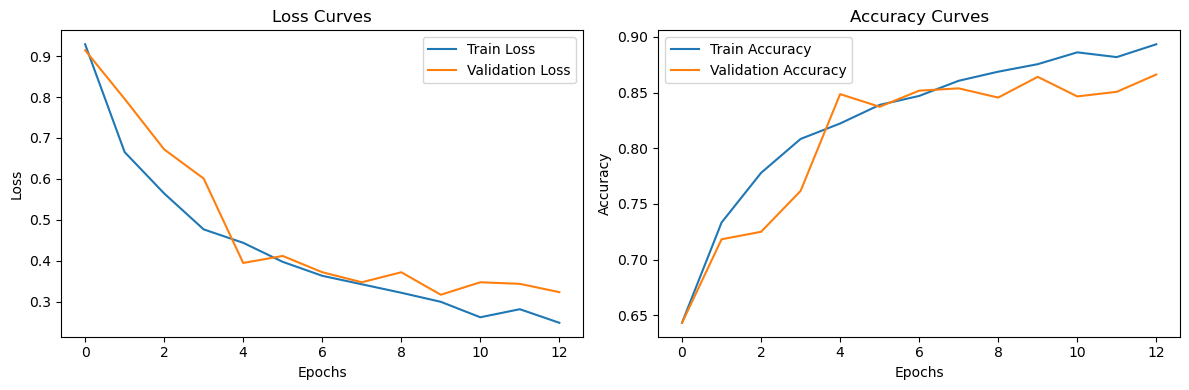

In [11]:
# Plotting loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plotting loss
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Loss Curves')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plotting accuracy
ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title('Accuracy Curves')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

In [12]:
# Generate classification report
class_names = test_dataset.classes
report = classification_report(test_true, test_preds, target_names=class_names)

# Display classification report
print("Classification Report:")
print(report)

Classification Report:
                     precision    recall  f1-score   support

           Calculus       0.70      0.51      0.59       130
             Caries       0.89      0.85      0.87       239
         Gingivitis       0.75      0.87      0.81       234
         Hypodontia       0.78      0.80      0.79        35
Tooth Discoloration       0.94      0.87      0.90       184
             Ulcers       0.91      1.00      0.96       255

           accuracy                           0.85      1077
          macro avg       0.83      0.82      0.82      1077
       weighted avg       0.85      0.85      0.85      1077



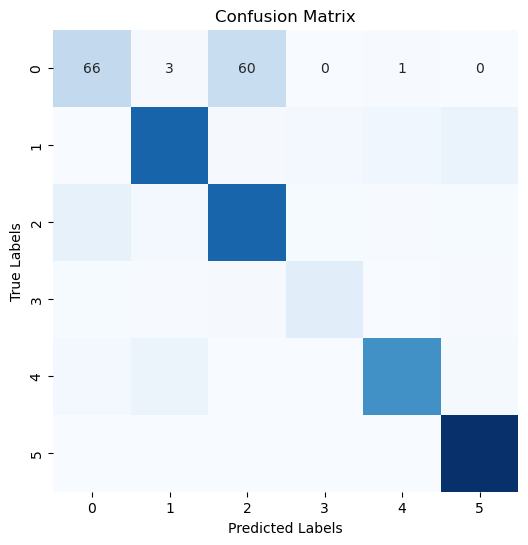

In [13]:
# Get predictions for the test set
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Prediction Sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

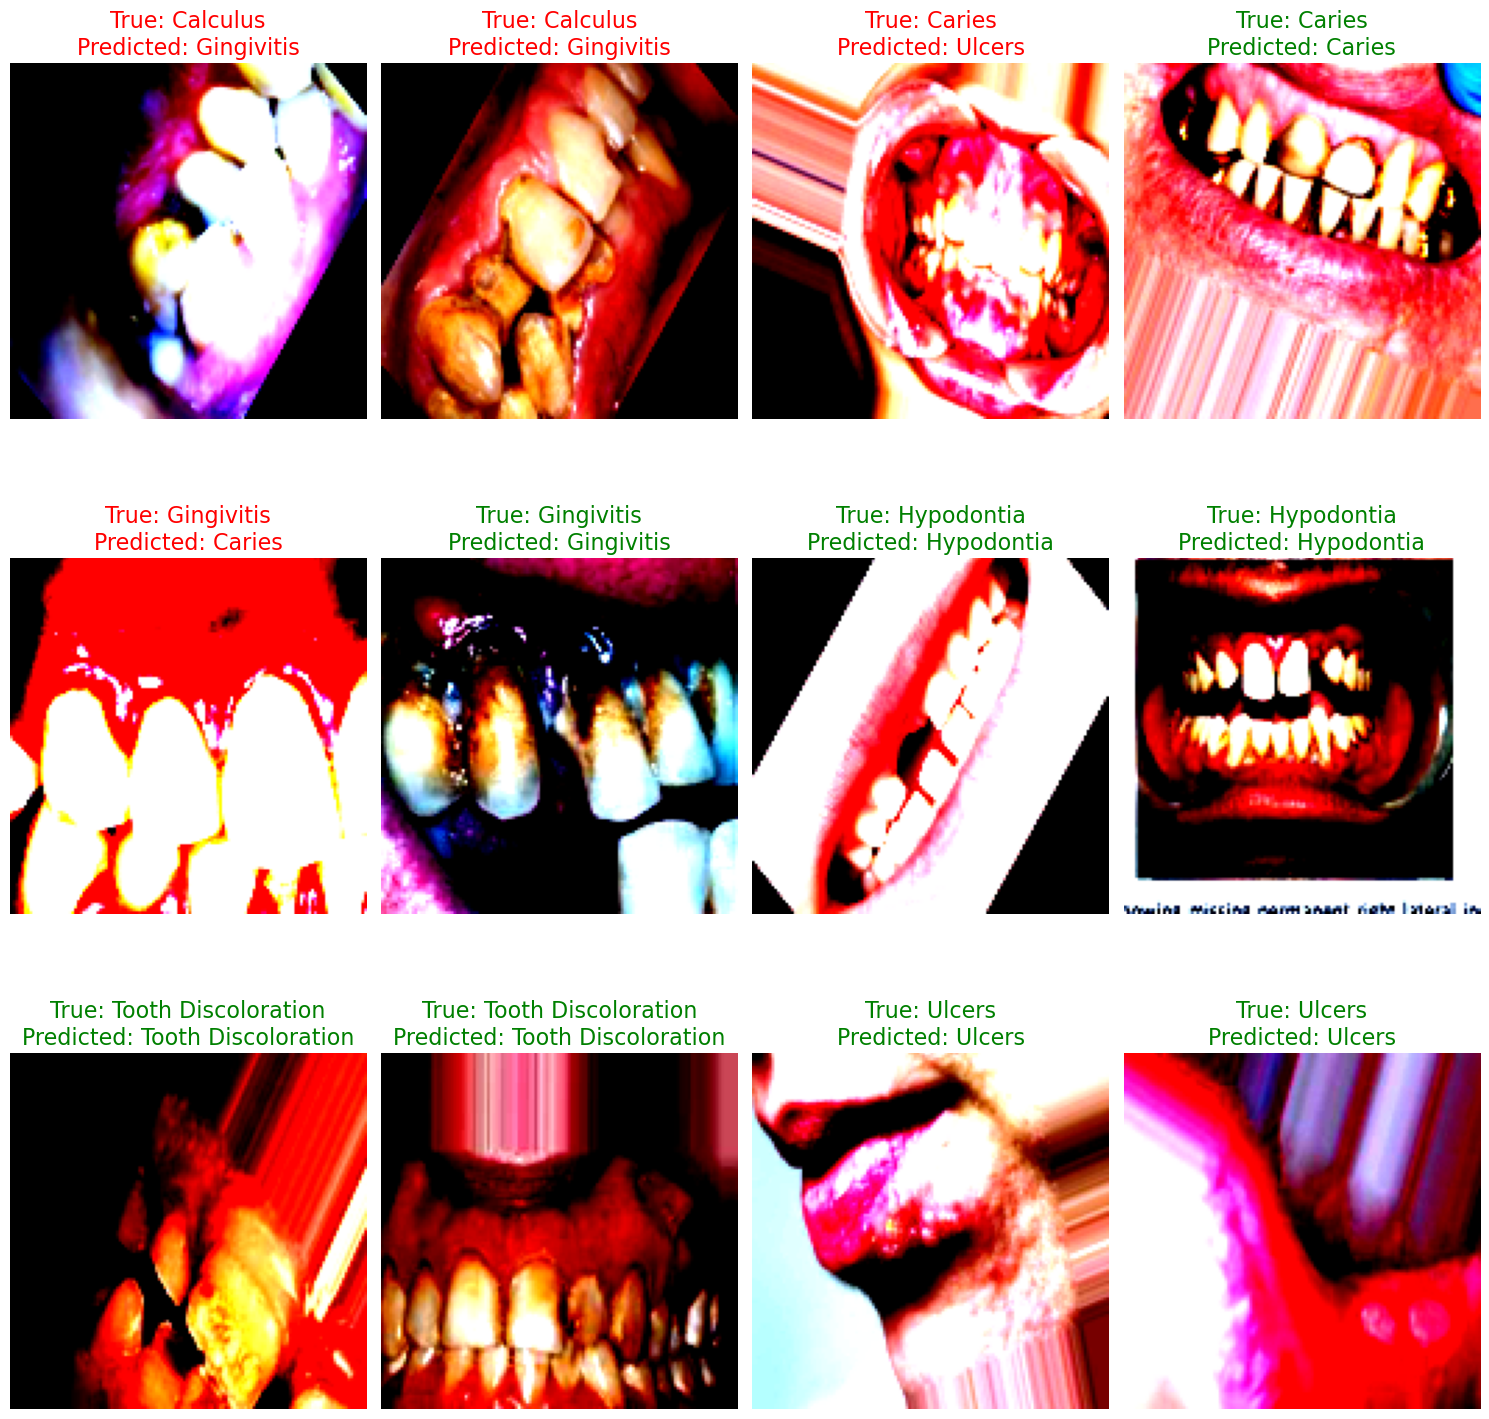

In [14]:
# Set seed for reproducibility
random.seed(42)

# Function to display random images with true and predicted classes
def display_random__predicted_images(model, test_loader, class_names, num_images_per_class=5):
    model.eval()
    plt.figure(figsize=(15, 30))
    images_so_far = 0
    class_counts = {classname: 0 for classname in class_names}
    shown_images = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                true_class_name = class_names[labels[j].item()]
                predicted_class_name = class_names[preds[j].item()]

                if class_counts[true_class_name] < num_images_per_class and (true_class_name, j) not in shown_images:
                    images_so_far += 1
                    ax = plt.subplot(len(class_names), num_images_per_class * 2, images_so_far)
                    ax.axis('off')
                    if true_class_name == predicted_class_name:
                        title_color = 'green'
                    else:
                        title_color = 'red'
                    ax.set_title(f'True: {true_class_name}\nPredicted: {predicted_class_name}', fontsize=16, color=title_color)
                    plt.imshow(inputs.cpu().data[j].permute(1, 2, 0))
                    class_counts[true_class_name] += 1
                    shown_images.append((true_class_name, j))

                if images_so_far >= len(class_names) * num_images_per_class:
                    return

# Display random predicted images
display_random__predicted_images(model, test_loader, class_names, num_images_per_class=2)
plt.tight_layout()
plt.show()

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Set seed for reproducibility
random.seed(42)

def visualize_grad_cam(image_paths, model, device, class_names):
    """
    Visualizes the Grad-CAM for a list of images and model.

    Parameters:
    - image_paths (list of str): List of paths to the input images.
    - model (torch.nn.Module): The pre-trained model.
    - device (torch.device): The device to run the model on (CPU or CUDA).
    - class_names (list of str): List of class names.

    Returns:
    - None: Displays the Grad-CAM visualization.
    """
    num_images = len(image_paths)
    num_rows = num_images // 2

    plt.figure(figsize=(20, 5 * num_rows))

    for idx, image_path in enumerate(image_paths):
        # Load and preprocess the image
        input_image = Image.open(image_path).convert('RGB')
        preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        input_tensor = preprocess(input_image).unsqueeze(0).to(device)

        # Access the appropriate layer in the model
        target_layer = model.model.layer4[-1]

        # Create an instance of Grad-CAM
        grad_cam = GradCAM(model=model, target_layers=[target_layer])

        # Generate the Grad-CAM
        grayscale_cam = grad_cam(input_tensor=input_tensor)[0]

        # Convert the input image to numpy array and scale to [0, 1]
        input_image_np = np.array(input_image.resize((224, 224))) / 255.0

        # Convert the grayscale cam to an RGB image
        visualization = show_cam_on_image(input_image_np, grayscale_cam, use_rgb=True)

        # Get the predicted class
        model.eval()
        with torch.no_grad():
            outputs = model(input_tensor)
            _, predicted = torch.max(outputs, 1)
            predicted_class = class_names[predicted.item()]

        # Get the true class from the image path
        true_class = os.path.basename(os.path.dirname(image_path))

        # Determine title color based on correct or incorrect prediction
        if true_class == predicted_class:
            title_color = 'green'
        else:
            title_color = 'red'

        # Plot the original image with true class
        plt.subplot(num_rows, 4, 2 * idx + 1)
        plt.imshow(input_image_np)
        plt.title(f'True: {true_class}', fontsize=24, color=title_color)
        plt.axis('off')

        # Plot the Grad-CAM visualization with predicted class
        plt.subplot(num_rows, 4, 2 * idx + 2)
        plt.imshow(visualization)
        plt.title(f'Predicted: {predicted_class}', fontsize=24, color=title_color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def get_random_images_from_folders(base_folder, num_images_per_folder=2):
    """
    Gets a specified number of random images from each subfolder.

    Parameters:
    - base_folder (str): The base folder containing subfolders with images.
    - num_images_per_folder (int): Number of random images to select from each subfolder.

    Returns:
    - list of str: List of paths to the randomly selected images.
    """
    image_paths = []
    subfolders = [f.path for f in os.scandir(base_folder) if f.is_dir()]
    for subfolder in subfolders:
        images = [os.path.join(subfolder, f) for f in os.listdir(subfolder) if f.endswith(('.jpg', '.jpeg', '.png'))]
        image_paths.extend(random.sample(images, min(num_images_per_folder, len(images))))
    return image_paths

# Get random images from the test folder
base_test_folder = '/kaggle/working/dataset/test'
random_images = get_random_images_from_folders(base_test_folder, num_images_per_folder=2)

# Visualize Grad-CAM for the selected images
visualize_grad_cam(random_images, model, device, class_names)